In [1]:
import netCDF4 as nc
from netCDF4 import num2date,date2index
import datetime
import csv
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.initializers import glorot_uniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

2024-01-10 15:18:58.442083: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 15:18:58.443298: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 15:18:58.461362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 15:18:58.461381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 15:18:58.461903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
vwind = nc.Dataset('Uwind.nc')
slp = nc.Dataset('SLP.nc')

In [3]:
vwind

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121013
    title: monthly mean uwnd.10m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 12-Dec-2023 06:05:39 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 uwnd(time, lat, lon)
    groups: 

In [4]:
slp

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.
    platform: Model
    NCO: 20121012
    title: monthly mean slp from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 12-Dec-2023 06:10:47 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(144), lat(73)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 slp(time, lat, lon)
    groups: 

In [5]:
v_wind = vwind.variables['uwnd']
print(vwind)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121013
    title: monthly mean uwnd.10m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 12-Dec-2023 06:05:39 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 uwnd(time, lat, lon)
    groups: 


In [6]:
slp_ = slp.variables['slp']
print(slp)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.
    platform: Model
    NCO: 20121012
    title: monthly mean slp from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 12-Dec-2023 06:10:47 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(144), lat(73)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 slp(time, lat, lon)
    groups: 


In [7]:
latitude = vwind.variables['lat']
print(latitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    actual_range: [ 88.542 -88.542]
unlimited dimensions: 
current shape = (94,)
filling off


In [8]:
latitude[:].shape

(94,)

In [9]:
latitude[:]

masked_array(data=[ 88.542   ,  86.6531  ,  84.7532  ,  82.8508  ,
                    80.9473  ,  79.0435  ,  77.1394  ,  75.2351  ,
                    73.3307  ,  71.4262  ,  69.5217  ,  67.6171  ,
                    65.7125  ,  63.8079  ,  61.9033  ,  59.9986  ,
                    58.0939  ,  56.1893  ,  54.2846  ,  52.3799  ,
                    50.4752  ,  48.5705  ,  46.6658  ,  44.7611  ,
                    42.8564  ,  40.9517  ,  39.047   ,  37.1422  ,
                    35.2375  ,  33.3328  ,  31.4281  ,  29.5234  ,
                    27.6186  ,  25.7139  ,  23.8092  ,  21.9044  ,
                    19.9997  ,  18.095   ,  16.1902  ,  14.2855  ,
                    12.3808  ,  10.47604 ,   8.57131 ,   6.66657 ,
                     4.76184 ,   2.8571  ,   0.952368,  -0.952368,
                    -2.8571  ,  -4.76184 ,  -6.66657 ,  -8.57131 ,
                   -10.47604 , -12.3808  , -14.2855  , -16.1902  ,
                   -18.095   , -19.9997  , -21.9044  , -23.809

In [10]:
latitude_slp = slp.variables['lat']
print(latitude_slp)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    actual_range: [ 90. -90.]
unlimited dimensions: 
current shape = (73,)
filling off


In [11]:
latitude_slp[:].shape

(73,)

In [12]:
latitude_slp[:]

masked_array(data=[ 90. ,  87.5,  85. ,  82.5,  80. ,  77.5,  75. ,  72.5,
                    70. ,  67.5,  65. ,  62.5,  60. ,  57.5,  55. ,  52.5,
                    50. ,  47.5,  45. ,  42.5,  40. ,  37.5,  35. ,  32.5,
                    30. ,  27.5,  25. ,  22.5,  20. ,  17.5,  15. ,  12.5,
                    10. ,   7.5,   5. ,   2.5,   0. ,  -2.5,  -5. ,  -7.5,
                   -10. , -12.5, -15. , -17.5, -20. , -22.5, -25. , -27.5,
                   -30. , -32.5, -35. , -37.5, -40. , -42.5, -45. , -47.5,
                   -50. , -52.5, -55. , -57.5, -60. , -62.5, -65. , -67.5,
                   -70. , -72.5, -75. , -77.5, -80. , -82.5, -85. , -87.5,
                   -90. ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [13]:
longitude = vwind.variables['lon']
print(longitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    actual_range: [  0.    358.125]
unlimited dimensions: 
current shape = (192,)
filling off


In [14]:
longitude[:]

masked_array(data=[  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,
                    11.25 ,  13.125,  15.   ,  16.875,  18.75 ,  20.625,
                    22.5  ,  24.375,  26.25 ,  28.125,  30.   ,  31.875,
                    33.75 ,  35.625,  37.5  ,  39.375,  41.25 ,  43.125,
                    45.   ,  46.875,  48.75 ,  50.625,  52.5  ,  54.375,
                    56.25 ,  58.125,  60.   ,  61.875,  63.75 ,  65.625,
                    67.5  ,  69.375,  71.25 ,  73.125,  75.   ,  76.875,
                    78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,
                    90.   ,  91.875,  93.75 ,  95.625,  97.5  ,  99.375,
                   101.25 , 103.125, 105.   , 106.875, 108.75 , 110.625,
                   112.5  , 114.375, 116.25 , 118.125, 120.   , 121.875,
                   123.75 , 125.625, 127.5  , 129.375, 131.25 , 133.125,
                   135.   , 136.875, 138.75 , 140.625, 142.5  , 144.375,
                   146.25 , 148.125, 150.   , 151.8

In [15]:
longitude_slp = slp.variables['lon']
print(longitude_slp)

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    actual_range: [  0.  357.5]
unlimited dimensions: 
current shape = (144,)
filling off


In [16]:
longitude_slp[:]

masked_array(data=[  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,
                    20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,
                    40. ,  42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,
                    60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,
                    80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
                   100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5,
                   120. , 122.5, 125. , 127.5, 130. , 132.5, 135. , 137.5,
                   140. , 142.5, 145. , 147.5, 150. , 152.5, 155. , 157.5,
                   160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
                   180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
                   200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5,
                   220. , 222.5, 225. , 227.5, 230. , 232.5, 235. , 237.5,
                   240. , 242.5, 245. , 247.5, 250. , 252.5, 255. , 257.5,
                   260. ,

In [17]:
time = vwind.variables['time']
time_ = time[:]
time_units = time.units
time_calendar = time.calendar
time_dates = num2date(time_, units=time_units, calendar=time_calendar)
start_date = datetime.datetime(1958, 1, 1)
start_index = date2index(start_date, time, select='nearest')
air_subset = vwind['uwnd'][start_index:, :, :]

In [18]:
slp_subset = slp['slp'][start_index:, :, :]

In [19]:
data_slp = np.array(slp_subset)

In [20]:
data_ = np.array(air_subset)
data_[data_ == -9.96921e+36] = 0

In [21]:
for date in time_dates:
    print(date)

1958-01-01 00:00:00
1958-02-01 00:00:00
1958-03-01 00:00:00
1958-04-01 00:00:00
1958-05-01 00:00:00
1958-06-01 00:00:00
1958-07-01 00:00:00
1958-08-01 00:00:00
1958-09-01 00:00:00
1958-10-01 00:00:00
1958-11-01 00:00:00
1958-12-01 00:00:00
1959-01-01 00:00:00
1959-02-01 00:00:00
1959-03-01 00:00:00
1959-04-01 00:00:00
1959-05-01 00:00:00
1959-06-01 00:00:00
1959-07-01 00:00:00
1959-08-01 00:00:00
1959-09-01 00:00:00
1959-10-01 00:00:00
1959-11-01 00:00:00
1959-12-01 00:00:00
1960-01-01 00:00:00
1960-02-01 00:00:00
1960-03-01 00:00:00
1960-04-01 00:00:00
1960-05-01 00:00:00
1960-06-01 00:00:00
1960-07-01 00:00:00
1960-08-01 00:00:00
1960-09-01 00:00:00
1960-10-01 00:00:00
1960-11-01 00:00:00
1960-12-01 00:00:00
1961-01-01 00:00:00
1961-02-01 00:00:00
1961-03-01 00:00:00
1961-04-01 00:00:00
1961-05-01 00:00:00
1961-06-01 00:00:00
1961-07-01 00:00:00
1961-08-01 00:00:00
1961-09-01 00:00:00
1961-10-01 00:00:00
1961-11-01 00:00:00
1961-12-01 00:00:00
1962-01-01 00:00:00
1962-02-01 00:00:00


In [22]:
data_

array([[[-1.9177394 , -1.9654821 , -2.0080626 , ..., -1.768063  ,
         -1.82129   , -1.8709657 ],
        [-1.2019339 , -1.280967  , -1.3548367 , ..., -0.9712884 ,
         -1.0448377 , -1.1245157 ],
        [-0.14515981, -0.32806298, -0.50870734, ...,  0.43516245,
          0.24290417,  0.04613126],
        ...,
        [-0.83258104, -0.7151598 , -0.60677266, ..., -1.1806434 ,
         -1.0632241 , -0.9499999 ],
        [-0.7529016 , -0.6438707 , -0.5322571 , ..., -1.0535475 ,
         -0.95193434, -0.852257  ],
        [-0.3354832 , -0.26354685, -0.1906438 , ..., -0.55290323,
         -0.4822565 , -0.40516022]],

       [[-1.0999985 , -1.1039293 , -1.1178561 , ..., -1.0735697 ,
         -1.0803555 , -1.0917833 ],
        [-0.5103553 , -0.5296418 , -0.54249793, ..., -0.48357064,
         -0.48821312, -0.5032125 ],
        [ 0.56214416,  0.46928623,  0.38035855, ...,  0.84928733,
          0.7557166 ,  0.6525012 ],
        ...,
        [-1.6146425 , -1.4700006 , -1.3625009 , ..., -

In [23]:
data_slp

array([[[1012.9961 , 1012.9961 , 1012.9961 , ..., 1012.9961 ,
         1012.9961 , 1012.9961 ],
        [1011.27997, 1011.2793 , 1011.2865 , ..., 1011.2904 ,
         1011.2788 , 1011.279  ],
        [1009.7007 , 1009.5694 , 1009.4475 , ..., 1010.13617,
         1009.9895 , 1009.8436 ],
        ...,
        [ 990.54675,  990.39264,  990.2639 , ...,  991.0222 ,
          990.871  ,  990.7112 ],
        [ 989.99097,  989.9565 ,  989.91583, ...,  990.1026 ,
          990.06866,  990.02954],
        [ 990.6226 ,  990.6226 ,  990.6226 , ...,  990.6226 ,
          990.6226 ,  990.6226 ]],

       [[1021.55176, 1021.55176, 1021.55176, ..., 1021.55176,
         1021.55176, 1021.55176],
        [1020.8135 , 1020.8164 , 1020.8158 , ..., 1020.7847 ,
         1020.79895, 1020.80505],
        [1020.3079 , 1020.2328 , 1020.15265, ..., 1020.44244,
         1020.414  , 1020.36755],
        ...,
        [1017.1109 , 1017.2514 , 1017.3432 , ..., 1016.1883 ,
         1016.6094 , 1016.9082 ],
        [101

In [24]:
np.max(data_)

14.4571

In [25]:
np.min(data_)

-14.469353

In [26]:
np.max(data_slp)

1082.5582

In [27]:
np.min(data_slp)

955.56085

In [28]:
data_.shape

(708, 94, 192)

In [29]:
data_slp.shape

(708, 73, 144)

In [30]:
len(data_)

708

In [31]:
num_years = data_.shape[0] // 12
num_months = data_.shape[0] // num_years

In [32]:
num_years

59

In [33]:
num_months

12

In [34]:
data_reshaped = np.reshape(data_, (len(data_) // 12, 12, data_.shape[1],data_.shape[2]))

In [35]:
data_reshaped_slp = np.reshape(data_slp, (len(data_) // 12, 12, data_slp.shape[1],data_slp.shape[2]))

In [36]:
lat_indices = []
for start_value in np.arange(90, -90, -10):  # Changed step to -10 for descending order
    end_value = start_value - 10  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((latitude <= start_value) & (latitude >= end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmax(latitude[range_indices])]
        max_index = range_indices[np.argmin(latitude[range_indices])]
        
        lat_indices.append(min_index)
        lat_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {latitude[min_index]}, Max = {latitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 90 to 80: Min index = 0, Max index = 4, Min = 88.54199981689453, Max = 80.94730377197266
Range 80 to 70: Min index = 5, Max index = 9, Min = 79.04350280761719, Max = 71.42620086669922
Range 70 to 60: Min index = 10, Max index = 14, Min = 69.52169799804688, Max = 61.90330123901367
Range 60 to 50: Min index = 15, Max index = 20, Min = 59.998600006103516, Max = 50.47520065307617
Range 50 to 40: Min index = 21, Max index = 25, Min = 48.570499420166016, Max = 40.951698303222656
Range 40 to 30: Min index = 26, Max index = 30, Min = 39.047000885009766, Max = 31.4281005859375
Range 30 to 20: Min index = 31, Max index = 35, Min = 29.523399353027344, Max = 21.904399871826172
Range 20 to 10: Min index = 36, Max index = 41, Min = 19.99970054626465, Max = 10.47603988647461
Range 10 to 0: Min index = 42, Max index = 46, Min = 8.571310043334961, Max = 0.9523680210113525
Range 0 to -10: Min index = 47, Max index = 51, Min = -0.9523680210113525, Max = -8.571310043334961
Range -10 to -20: Min inde

In [37]:
lat_indices_slp = []
for start_value in np.arange(90, -90, -10):  # Changed step to -10 for descending order
    end_value = start_value - 10  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((latitude_slp <= start_value) & (latitude_slp > end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmax(latitude_slp[range_indices])]
        max_index = range_indices[np.argmin(latitude_slp[range_indices])]
        
        lat_indices_slp.append(min_index)
        lat_indices_slp.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {latitude_slp[min_index]}, Max = {latitude_slp[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 90 to 80: Min index = 0, Max index = 3, Min = 90.0, Max = 82.5
Range 80 to 70: Min index = 4, Max index = 7, Min = 80.0, Max = 72.5
Range 70 to 60: Min index = 8, Max index = 11, Min = 70.0, Max = 62.5
Range 60 to 50: Min index = 12, Max index = 15, Min = 60.0, Max = 52.5
Range 50 to 40: Min index = 16, Max index = 19, Min = 50.0, Max = 42.5
Range 40 to 30: Min index = 20, Max index = 23, Min = 40.0, Max = 32.5
Range 30 to 20: Min index = 24, Max index = 27, Min = 30.0, Max = 22.5
Range 20 to 10: Min index = 28, Max index = 31, Min = 20.0, Max = 12.5
Range 10 to 0: Min index = 32, Max index = 35, Min = 10.0, Max = 2.5
Range 0 to -10: Min index = 36, Max index = 39, Min = 0.0, Max = -7.5
Range -10 to -20: Min index = 40, Max index = 43, Min = -10.0, Max = -17.5
Range -20 to -30: Min index = 44, Max index = 47, Min = -20.0, Max = -27.5
Range -30 to -40: Min index = 48, Max index = 51, Min = -30.0, Max = -37.5
Range -40 to -50: Min index = 52, Max index = 55, Min = -40.0, Max = -47.

In [38]:
lat_indices

[0,
 4,
 5,
 9,
 10,
 14,
 15,
 20,
 21,
 25,
 26,
 30,
 31,
 35,
 36,
 41,
 42,
 46,
 47,
 51,
 52,
 57,
 58,
 62,
 63,
 67,
 68,
 72,
 73,
 78,
 79,
 83,
 84,
 88,
 89,
 93]

In [39]:
lat_indices_slp

[0,
 3,
 4,
 7,
 8,
 11,
 12,
 15,
 16,
 19,
 20,
 23,
 24,
 27,
 28,
 31,
 32,
 35,
 36,
 39,
 40,
 43,
 44,
 47,
 48,
 51,
 52,
 55,
 56,
 59,
 60,
 63,
 64,
 67,
 68,
 71]

In [40]:
len(lat_indices)

36

In [41]:
len(lat_indices_slp)

36

In [42]:
lon_indices = []
for start_value in np.arange(0, 360, 20):  # Changed step to -10 for descending order
    end_value = start_value + 20  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((longitude >= start_value) & (longitude < end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmin(longitude[range_indices])]
        max_index = range_indices[np.argmax(longitude[range_indices])]
        
        lon_indices.append(min_index)
        lon_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {longitude[min_index]}, Max = {longitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 0 to 20: Min index = 0, Max index = 10, Min = 0.0, Max = 18.75
Range 20 to 40: Min index = 11, Max index = 21, Min = 20.625, Max = 39.375
Range 40 to 60: Min index = 22, Max index = 31, Min = 41.25, Max = 58.125
Range 60 to 80: Min index = 32, Max index = 42, Min = 60.0, Max = 78.75
Range 80 to 100: Min index = 43, Max index = 53, Min = 80.625, Max = 99.375
Range 100 to 120: Min index = 54, Max index = 63, Min = 101.25, Max = 118.125
Range 120 to 140: Min index = 64, Max index = 74, Min = 120.0, Max = 138.75
Range 140 to 160: Min index = 75, Max index = 85, Min = 140.625, Max = 159.375
Range 160 to 180: Min index = 86, Max index = 95, Min = 161.25, Max = 178.125
Range 180 to 200: Min index = 96, Max index = 106, Min = 180.0, Max = 198.75
Range 200 to 220: Min index = 107, Max index = 117, Min = 200.625, Max = 219.375
Range 220 to 240: Min index = 118, Max index = 127, Min = 221.25, Max = 238.125
Range 240 to 260: Min index = 128, Max index = 138, Min = 240.0, Max = 258.75
Range 2

In [43]:
lon_indices_slp = []
for start_value in np.arange(0, 360, 20):  # Changed step to -10 for descending order
    end_value = start_value + 20  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((longitude_slp >= start_value) & (longitude_slp < end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmin(longitude_slp[range_indices])]
        max_index = range_indices[np.argmax(longitude_slp[range_indices])]
        
        lon_indices_slp.append(min_index)
        lon_indices_slp.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {longitude_slp[min_index]}, Max = {longitude_slp[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 0 to 20: Min index = 0, Max index = 7, Min = 0.0, Max = 17.5
Range 20 to 40: Min index = 8, Max index = 15, Min = 20.0, Max = 37.5
Range 40 to 60: Min index = 16, Max index = 23, Min = 40.0, Max = 57.5
Range 60 to 80: Min index = 24, Max index = 31, Min = 60.0, Max = 77.5
Range 80 to 100: Min index = 32, Max index = 39, Min = 80.0, Max = 97.5
Range 100 to 120: Min index = 40, Max index = 47, Min = 100.0, Max = 117.5
Range 120 to 140: Min index = 48, Max index = 55, Min = 120.0, Max = 137.5
Range 140 to 160: Min index = 56, Max index = 63, Min = 140.0, Max = 157.5
Range 160 to 180: Min index = 64, Max index = 71, Min = 160.0, Max = 177.5
Range 180 to 200: Min index = 72, Max index = 79, Min = 180.0, Max = 197.5
Range 200 to 220: Min index = 80, Max index = 87, Min = 200.0, Max = 217.5
Range 220 to 240: Min index = 88, Max index = 95, Min = 220.0, Max = 237.5
Range 240 to 260: Min index = 96, Max index = 103, Min = 240.0, Max = 257.5
Range 260 to 280: Min index = 104, Max index = 1

In [44]:
lon_indices

[0,
 10,
 11,
 21,
 22,
 31,
 32,
 42,
 43,
 53,
 54,
 63,
 64,
 74,
 75,
 85,
 86,
 95,
 96,
 106,
 107,
 117,
 118,
 127,
 128,
 138,
 139,
 149,
 150,
 159,
 160,
 170,
 171,
 181,
 182,
 191]

In [45]:
lon_indices_slp

[0,
 7,
 8,
 15,
 16,
 23,
 24,
 31,
 32,
 39,
 40,
 47,
 48,
 55,
 56,
 63,
 64,
 71,
 72,
 79,
 80,
 87,
 88,
 95,
 96,
 103,
 104,
 111,
 112,
 119,
 120,
 127,
 128,
 135,
 136,
 143]

In [46]:
len(lon_indices)

36

In [47]:
len(lon_indices_slp)

36

In [48]:
for lat_idx in range(0, len(lat_indices), 2):
    lat_range_start = lat_indices[lat_idx]
    lat_range_end = lat_indices[lat_idx + 1]
    print(lat_range_start,lat_range_end)

0 4
5 9
10 14
15 20
21 25
26 30
31 35
36 41
42 46
47 51
52 57
58 62
63 67
68 72
73 78
79 83
84 88
89 93


In [49]:
for lon_idx in range(0, len(lon_indices),2):
    lon_range_start = lon_indices[lon_idx]
    lon_range_end = lon_indices[lon_idx + 1]
    print(lon_range_start,lon_range_end)

0 10
11 21
22 31
32 42
43 53
54 63
64 74
75 85
86 95
96 106
107 117
118 127
128 138
139 149
150 159
160 170
171 181
182 191


In [50]:
def coarse_gridding(data, lat_indices, lon_indices):
    coarsed_data = np.zeros((data.shape[0], data.shape[1], len(lat_indices) // 2, len(lon_indices) // 2))
    for lat_idx in range(0, len(lat_indices), 2):
        lat_range_start = lat_indices[lat_idx]
        lat_range_end = lat_indices[lat_idx + 1]
        for lon_idx in range(0, len(lon_indices), 2):
            lon_range_start = lon_indices[lon_idx]
            lon_range_end = lon_indices[lon_idx + 1]
            subset = data[:, :, lat_range_start:lat_range_end, lon_range_start:lon_range_end]
            averaged_value = np.mean(subset, axis=(2, 3))
            coarsed_data[:, :, lat_idx // 2, lon_idx // 2] = averaged_value
    return coarsed_data


In [51]:
 avg = coarse_gridding(data_reshaped,lat_indices,lon_indices)

In [52]:
 avg_slp = coarse_gridding(data_reshaped_slp,lat_indices_slp,lon_indices_slp)

In [53]:
avg.shape

(59, 12, 18, 18)

In [54]:
avg_slp.shape

(59, 12, 18, 18)

In [55]:
avg[1,1,:,1]

array([-1.2457664 ,  2.59887648,  3.62728739,  2.78565884,  2.11086726,
       -0.30434674, -0.01990912, -1.93297029, -0.04824876,  0.23840313,
        0.28967264, -1.60621297, -1.26453412,  4.78515339,  5.95834398,
       -0.56822199, -2.44381118,  1.10731387])

In [56]:
avg_slp[1,1,:,1]

array([ 997.65979004,  993.06195068, 1007.27862549, 1020.58447266,
       1027.33666992, 1024.19238281, 1020.79614258, 1012.87451172,
       1007.64080811, 1010.81072998, 1009.41046143, 1008.9833374 ,
       1011.87927246, 1011.84533691,  997.52874756,  986.6237793 ,
        998.32653809, 1010.23895264])

In [57]:
final= np.reshape(avg, (len(data_) // 12, 12, 324))

In [58]:
final_slp= np.reshape(avg_slp, (len(data_slp) // 12, 12, 324))

In [59]:
final.shape

(59, 12, 324)

In [60]:
final_slp.shape

(59, 12, 324)

In [61]:
np.max(final)

12.473066329956055

In [62]:
np.max(final_slp)

1068.5726318359375

In [63]:
np.min(final)

-11.231135368347168

In [64]:
np.min(final_slp)

958.583984375

In [65]:
ff= final.reshape(324,708)
ff.shape

(324, 708)

In [66]:
ff_slp= final_slp.reshape(324,708)
ff_slp.shape

(324, 708)

In [67]:
def calculate_monthly_anomaliess(data):
    """Calculate monthly anomalies and mean for a given dataset.

    Args:
        data: A multidimensional array with dimensions (years, months, latlon).

    Returns:
        monthly_anomalies: An array with monthly anomalies of the same shape as the input data.
        monthly_mean: A multidimensional array with dimensions (months, latlon) representing the mean for each month.
    """


    anomalies = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]
            monthly_mean = np.mean(month)
            anomalies[:, j, i] = month - monthly_mean
    return anomalies

def min_max_normalize(data):
    normalized_data = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]

            # Calculate min and max values for each month
            min_value = np.min(month)
            max_value = np.max(month)

            # Normalize each month value
            normalized_month = (month - min_value) / (max_value - min_value)

            # Store normalized month data
            normalized_data[:, j, i] = normalized_month


    return normalized_data




In [68]:
anomalies = calculate_monthly_anomaliess(final)
anomalies

array([[[-8.30644717e-02, -3.46639101e-01, -3.50536007e-01, ...,
          1.76584383e+00,  7.66954858e-01, -1.48629783e-01],
        [ 6.29740269e-01,  8.98667817e-01,  7.77669294e-01, ...,
          5.55390415e-01,  4.21353114e-03,  3.92696817e-02],
        [ 1.01019101e+00,  1.25849842e+00,  1.00719024e+00, ...,
          1.37010429e-01,  1.18473619e-01,  4.32280359e-01],
        ...,
        [ 1.04663317e+00,  1.09966675e+00,  1.20716304e+00, ...,
          1.03480646e-01,  2.05529577e-01,  4.93398028e-01],
        [-7.65522833e-01, -1.23136230e+00, -1.86186759e+00, ...,
          8.95559315e-01,  7.74346986e-01,  7.57323274e-01],
        [-1.38825697e+00, -1.15340834e+00, -6.00852386e-01, ...,
          1.47119054e+00,  8.52826630e-01,  4.91073572e-01]],

       [[ 1.37675783e+00,  5.97143109e-01, -3.52130789e-01, ...,
         -1.64405924e-01, -1.59157793e-01, -2.06172277e-03],
        [ 7.57240460e-01,  3.08641140e-01,  3.26081975e-01, ...,
          4.52677068e-01,  3.01337917e

In [69]:
anomalies_slp = calculate_monthly_anomaliess(final_slp)
anomalies_slp

array([[[-1.36071570e+00, -1.43362272e+00, -1.28568281e+00, ...,
         -1.96499479e+00, -4.14394780e+00, -7.02194886e+00],
        [ 7.84649451e+00,  7.63605357e+00,  7.21721378e+00, ...,
          4.62494103e+00,  2.72797355e+00,  1.16117626e+00],
        [ 9.91077074e+00,  9.80127263e+00,  9.42240776e+00, ...,
         -7.07677809e-01, -1.09490243e+00, -2.25057621e+00],
        ...,
        [-3.06941559e+00, -3.00015414e+00, -2.92287639e+00, ...,
          2.17967922e-03, -5.10594255e-01, -1.94822667e+00],
        [-2.25862147e-01, -1.50836492e-01,  2.29295634e-01, ...,
          2.50864113e+00,  1.39477125e+00, -2.23173497e-01],
        [ 9.87339136e+00,  1.01615870e+01,  1.03655768e+01, ...,
         -3.12487483e+00, -4.86838234e+00, -6.59111928e+00]],

       [[ 1.14600240e+01,  1.06411454e+01,  9.86177813e+00, ...,
         -1.78939664e+00, -1.90853520e+00, -2.14548402e+00],
        [-1.48138448e+01, -1.52116027e+01, -1.54559430e+01, ...,
         -8.86472540e-01, -2.55596200e

In [70]:
np.max((anomalies))

8.421037404750615

In [71]:
np.max((anomalies_slp))

26.268446065611784

In [72]:
np.min((anomalies))

-9.978876512434523

In [73]:
np.min((anomalies_slp))

-27.711992684057122

In [74]:
num_positive_values = np.sum(anomalies > 0)

# Find the number of negative values
num_negative_values = np.sum(anomalies < 0)

# Find the number of zero values (optional)
num_zero_values = np.sum(anomalies == 0)

print("Number of positive values:", num_positive_values)
print("Number of negative values:", num_negative_values)
print("Number of zero values:", num_zero_values)

Number of positive values: 115212
Number of negative values: 114180
Number of zero values: 0


In [75]:
num_positive_values = np.sum(anomalies_slp > 0)

# Find the number of negative values
num_negative_values = np.sum(anomalies_slp < 0)

# Find the number of zero values (optional)
num_zero_values = np.sum(anomalies_slp == 0)

print("Number of positive values:", num_positive_values)
print("Number of negative values:", num_negative_values)
print("Number of zero values:", num_zero_values)

Number of positive values: 115911
Number of negative values: 113481
Number of zero values: 0


In [76]:


# Assuming normalized_data_slp and normalized_data_vwind are your arrays
# with shape (59, 12, 324)

combined_anomalies = np.concatenate((anomalies, anomalies_slp), axis=2)

# Now combined_data has shape (59, 12, 648)


In [77]:
normalized_data = min_max_normalize(combined_anomalies)
normalized_data

array([[[0.55350666, 0.51835964, 0.55477328, ..., 0.45165511,
         0.30510256, 0.08453275],
        [0.65420241, 0.74750849, 0.67075624, ..., 0.75271577,
         0.60420305, 0.54066492],
        [0.71465552, 0.81995338, 0.75647848, ..., 0.44882843,
         0.41555007, 0.37433847],
        ...,
        [0.72446625, 0.71898243, 0.79285941, ..., 0.42876342,
         0.35203393, 0.30147993],
        [0.48348266, 0.39102637, 0.22077193, ..., 0.60782399,
         0.55089168, 0.4755579 ],
        [0.25476706, 0.29215833, 0.35200443, ..., 0.27708886,
         0.21258464, 0.16174425]],

       [[0.7375101 , 0.63082017, 0.55455556, ..., 0.46083524,
         0.42424893, 0.37507   ],
        [0.67180938, 0.65031901, 0.5976545 , ..., 0.4714061 ,
         0.29437112, 0.22985542],
        [1.        , 1.        , 0.79752272, ..., 0.55925702,
         0.4546381 , 0.4087468 ],
        ...,
        [0.3970711 , 0.48134033, 0.62568077, ..., 0.36838535,
         0.2710822 , 0.30632488],
        [0.5

In [78]:
tf.random.set_seed(12345)

In [79]:
input_dim = 648
hidden_dim = 65
input_layer = Input(shape = (input_dim,))
hidden_layer = Dense(hidden_dim,activation='tanh')(input_layer)
output_layer = Dense(input_dim,activation='linear')(hidden_layer)

2024-01-10 15:19:00.515510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 15:19:00.515805: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [80]:
input_data = normalized_data.reshape(-1, input_dim)
input_data.shape

(708, 648)

In [81]:
input_data

array([[0.55350666, 0.51835964, 0.55477328, ..., 0.45165511, 0.30510256,
        0.08453275],
       [0.65420241, 0.74750849, 0.67075624, ..., 0.75271577, 0.60420305,
        0.54066492],
       [0.71465552, 0.81995338, 0.75647848, ..., 0.44882843, 0.41555007,
        0.37433847],
       ...,
       [0.42983123, 0.48453507, 0.62568603, ..., 0.3859323 , 0.28612803,
        0.22191595],
       [0.53824573, 0.5909304 , 0.64484527, ..., 0.66361371, 0.79231947,
        0.82612814],
       [0.34522571, 0.29947594, 0.34510212, ..., 0.48158901, 0.57336781,
        0.70714447]])

In [82]:
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [83]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [84]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 648)]             0         
                                                                 
 dense (Dense)               (None, 65)                42185     
                                                                 
 dense_1 (Dense)             (None, 648)               42768     
                                                                 
Total params: 84953 (331.85 KB)
Trainable params: 84953 (331.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
autoencoder.fit(input_data, input_data, epochs=10
                , batch_size=8)

Epoch 1/10
89/89 [==============================] - 0s 537us/step - loss: 0.0806
Epoch 2/10
89/89 [==============================] - 0s 407us/step - loss: 0.0459
Epoch 3/10
89/89 [==============================] - 0s 402us/step - loss: 0.0393
Epoch 4/10
89/89 [==============================] - 0s 437us/step - loss: 0.0351
Epoch 5/10
89/89 [==============================] - 0s 457us/step - loss: 0.0316
Epoch 6/10
89/89 [==============================] - 0s 460us/step - loss: 0.0290
Epoch 7/10
89/89 [==============================] - 0s 472us/step - loss: 0.0268
Epoch 8/10
89/89 [==============================] - 0s 469us/step - loss: 0.0251
Epoch 9/10
89/89 [==============================] - 0s 426us/step - loss: 0.0238
Epoch 10/10
89/89 [==============================] - 0s 413us/step - loss: 0.0227


In [86]:
encoded_data = autoencoder.predict(input_data)

23/23 [==============================] - 0s 361us/step


In [87]:
encoded_data.shape

(708, 648)

In [88]:
decoded_data = autoencoder.predict(encoded_data)

23/23 [==============================] - 0s 347us/step


In [89]:
decoded_data.shape

(708, 648)

In [90]:
weights = autoencoder.get_weights()[0]# Get the weights of the first layer (between input and hidden)
weights

array([[ 0.0011417 ,  0.00224719, -0.08227499, ..., -0.0133572 ,
        -0.13313366,  0.01481866],
       [ 0.00556777, -0.00683577, -0.00146258, ...,  0.06959946,
         0.02899272, -0.0069419 ],
       [-0.03811463, -0.07043718,  0.03035186, ...,  0.04946827,
         0.06588517, -0.00421402],
       ...,
       [ 0.00014113,  0.05885485,  0.01431824, ...,  0.07182559,
        -0.09486971,  0.02049726],
       [ 0.09422146,  0.0199211 ,  0.05524885, ...,  0.04107367,
        -0.0462004 , -0.07249588],
       [-0.01520764, -0.05316364,  0.05036295, ...,  0.0772023 ,
        -0.02312928, -0.06628415]], dtype=float32)

In [91]:
np.save('weights.npy', weights)

In [92]:
weights = np.load('weights.npy')

In [93]:
weights

array([[ 0.0011417 ,  0.00224719, -0.08227499, ..., -0.0133572 ,
        -0.13313366,  0.01481866],
       [ 0.00556777, -0.00683577, -0.00146258, ...,  0.06959946,
         0.02899272, -0.0069419 ],
       [-0.03811463, -0.07043718,  0.03035186, ...,  0.04946827,
         0.06588517, -0.00421402],
       ...,
       [ 0.00014113,  0.05885485,  0.01431824, ...,  0.07182559,
        -0.09486971,  0.02049726],
       [ 0.09422146,  0.0199211 ,  0.05524885, ...,  0.04107367,
        -0.0462004 , -0.07249588],
       [-0.01520764, -0.05316364,  0.05036295, ...,  0.0772023 ,
        -0.02312928, -0.06628415]], dtype=float32)

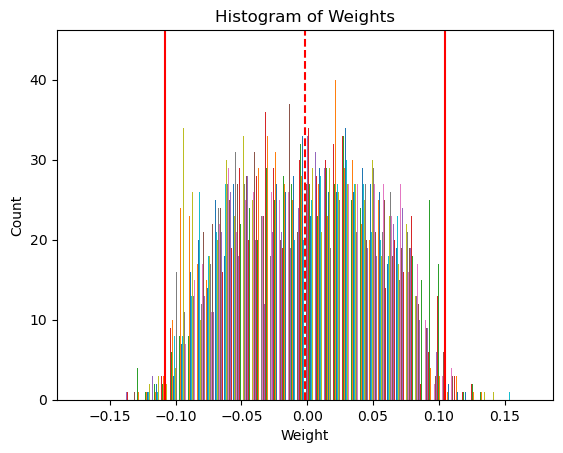

In [94]:
import matplotlib.pyplot as plt
# Calculate the mean and standard deviation of the weights.
mean = np.mean(weights)
sigma = np.std(weights)

# Plot a histogram of the weights.
plt.hist(weights, bins=50)
plt.axvline(mean, color='red', linestyle='dashed')
plt.axvline(mean + 2*sigma, color='red')
plt.axvline(mean - 2*sigma, color='red')
plt.title('Histogram of Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

In [95]:
weights.shape

(648, 65)

In [146]:
def Tweights(weight):
    num = []

    for i in range(weight.shape[1]):
        weight_mean = np.mean(weight[:, i])
        weight_std = np.std(weight[:, i])
        threshold_upper = weight_mean + 1.5 * weight_std
        threshold_lower = weight_mean - 1.5 * weight_std
        nodes_with_weight_above_upper_threshold = np.sum(weight[:, i] > threshold_upper)
        nodes_with_weight_below_lower_threshold = np.sum(weight[:, i] < threshold_lower)
        ten_percent_nodes = int(0.1 * weight.shape[0])

        if nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold > ten_percent_nodes:
            num.append(nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold)
            print(i, nodes_with_weight_above_upper_threshold, threshold_upper, nodes_with_weight_below_lower_threshold, threshold_lower)

    return num




In [147]:
we = Tweights(weights)
we

0 50 0.08232652032165788 37 -0.08148530489415862
1 52 0.07637368072755635 45 -0.079657994909212
2 41 0.0770773789845407 42 -0.08669635886326432
3 33 0.08144711519707926 51 -0.08080435727606528
4 39 0.08099454312468879 39 -0.08033499823068269
5 46 0.07503748964518309 37 -0.08288915548473597
6 46 0.0815298463230647 40 -0.08150175781793223
7 37 0.06822988204658031 43 -0.09149550832808018
8 48 0.07483597984537482 36 -0.08488742122426629
9 40 0.0818671225279104 40 -0.08132317897980101
10 41 0.08324329214519821 43 -0.08239648086600937
11 47 0.0695039601996541 42 -0.0923101669177413
12 43 0.07816807564813644 46 -0.07462131220381707
13 42 0.0784552046097815 45 -0.07281486829742789
14 40 0.07779556905734353 39 -0.07843317071092315
15 45 0.08059942536056042 37 -0.07508532889187336
16 42 0.07615667848585872 46 -0.07636995346547337
17 42 0.07001375313848257 41 -0.08429995644837618
18 41 0.08097265323158354 40 -0.07831336895469576
19 47 0.07269976427778602 38 -0.08373056584969163
20 34 0.0819304531

[87,
 97,
 83,
 84,
 78,
 83,
 86,
 80,
 84,
 80,
 84,
 89,
 89,
 87,
 79,
 82,
 88,
 83,
 81,
 85,
 78,
 86,
 84,
 86,
 80,
 80,
 82,
 79,
 93,
 86,
 87,
 87,
 82,
 90,
 82,
 86,
 71,
 85,
 78,
 81,
 84,
 84,
 93,
 90,
 93,
 93,
 81,
 88,
 88,
 81,
 90,
 87,
 81,
 80,
 81,
 92,
 86,
 91,
 78,
 96,
 87,
 87,
 86,
 95,
 82]

In [148]:
len(we)

65

In [99]:
pred = np.zeros((65,708))
for i in range(weights.shape[1]):
    weight_mean = np.mean(weights[:,i])
    weight_std = np.std(weights[:,i])
    threshold_upper = weight_mean + 1.5 * weight_std
    threshold_lower = weight_mean - 1.5 * weight_std
    nodes_with_weight_above_upper_threshold = np.sum(weights[:, i] > threshold_upper)
    nodes_with_weight_below_lower_threshold = np.sum(weights[:, i] < threshold_lower)
    ten_percent_nodes = int(0.1 * weights.shape[0])
    if (nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold) > ten_percent_nodes:
        for h in range(input_data.shape[0]): 
            pred_i = 0
            for j in range(weights.shape[0]):
                weight_value = weights[j,i]
                if weight_value > threshold_upper or weight_value < threshold_lower:
                    pp = np.sum(weight_value*input_data[h,j])
                    pred_i += pp
                    pred[i,h] = pred_i
                

print(pred)

[[ 0.64455898  0.95648002  1.04669257 ...  0.52263877 -0.0921795
   0.55853291]
 [ 0.50468379 -0.04715775  0.01875835 ...  0.31365906  0.51611354
   0.80962246]
 [-0.13782798 -0.49311985 -0.75739809 ... -0.55947986 -0.44486315
  -0.40059515]
 ...
 [ 0.05115979 -0.24069934  0.01758824 ...  0.54262442  0.1566868
   0.1111986 ]
 [ 0.86438567  0.2809807   0.42440636 ...  0.13125827  0.2148866
  -0.16877212]
 [-0.31188975  0.06140164 -0.07695098 ... -0.9529569  -0.49826383
  -0.27286986]]


In [100]:
weight_value

-0.06628415

In [101]:
number_of_zeros = np.count_nonzero( pred == 0)

In [102]:
number_of_zeros

0

In [103]:
pred.shape

(65, 708)

In [104]:
predd = pred[12,:].reshape(59,12)
predd

array([[-3.62170197e-01, -2.46763543e-01, -3.34369063e-02,
        -3.02785003e-02, -2.05893878e-01,  3.84240021e-01,
         2.27191558e-01,  1.28566401e-01, -1.64171695e-01,
        -2.99899322e-01, -4.44654825e-01, -3.39639211e-01],
       [-4.85797255e-01, -7.38528892e-02, -8.84694742e-02,
        -1.52446379e-02,  2.38473808e-01,  3.14567943e-01,
         3.02315930e-01, -1.55361401e-02, -4.29090030e-01,
         1.10430468e-02, -2.17564483e-01, -3.74942771e-01],
       [ 1.33959294e-01,  4.93853960e-02,  1.46238682e-02,
        -2.55417898e-01,  2.63219196e-02, -1.95838253e-01,
        -6.29406412e-02,  3.63691616e-02, -7.79036619e-04,
        -5.28987373e-01, -1.76642159e-01, -1.11083895e-01],
       [-4.55269481e-01,  1.12810360e-01, -4.34979070e-01,
        -4.52912161e-01, -1.97339932e-02, -1.29546448e-01,
         3.14083366e-01,  4.81444763e-02, -3.42681620e-01,
        -3.86348761e-01, -2.17758834e-02, -9.47900487e-02],
       [-8.56481825e-02, -3.24195687e-02,  7.9949868

In [105]:
df = pd.read_csv("enso_index.csv")
df

,year,january,february,march,april,may,june,july,august,september,october,november,december,avg
0,1958,1.54,1.40,0.99,0.31,0.32,0.30,0.04,0.24,-0.31,-0.03,0.05,0.30,0.0675
1,1959,0.43,0.50,0.26,0.27,-0.01,-0.33,-0.28,-0.41,-0.53,0.11,-0.17,-0.05,-0.3875
2,1960,0.02,-0.24,-0.08,0.01,0.05,-0.20,-0.25,0.00,0.03,-0.07,-0.38,0.02,-0.1050
3,1961,-0.15,0.04,-0.10,0.13,-0.01,0.10,-0.32,-0.25,-0.52,-0.71,-0.19,-0.29,-0.2475
4,1962,-0.25,-0.16,-0.41,-0.32,-0.42,-0.22,-0.30,-0.13,-0.56,-0.33,-0.43,-0.49,-0.3025
5,1963,-0.32,-0.26,-0.06,-0.06,0.00,0.12,0.72,0.90,0.65,0.84,0.75,1.05,0.5975
6,1964,0.76,0.55,-0.16,-0.53,-0.74,-0.88,-0.65,-0.76,-0.93,-1.00,-1.10,-1.07,-0.8050
7,1965,-0.57,-0.36,-0.34,-0.09,0.19,0.45,0.81,1.25,1.26,1.61,1.54,1.45,0.9425
8,1966,1.13,0.83,0.83,0.54,-0.06,0.14,0.23,-0.10,-0.05,-0.05,-0.37,-0.26,0.0550
9,1967,-0.55,-0.56,-0.47,-0.53,-0.24,-0.12,-0.10,-0.31,-0.59,-0.38,-0.34,-0.35,-0.2800


In [106]:
pred_pres = pred[12,:].reshape(59,12)
years = pd.date_range(start='1958', end='2016', freq='YS').year
months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
df_pres = df_pres.reset_index()
df_pres['enso_avg'] = df['avg'].copy()
df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
df_pres.index = df_pres.index + 1  # shifting index
df_pres = df_pres.sort_index() 
df_pres= df_pres.drop('index',axis=1)
df_6 = df_pres.iloc[1:, :5]
df_6 = df_6.reset_index()
df_12 = df_pres.iloc[0:-1, 5:12]
df_12 = df_12.reset_index()
df_13 = df_pres.iloc[1:, [12]]
df_13 = df_13.reset_index()
df_last = pd.concat([df_6, df_12, df_13], axis=1)
df_last = df_last.drop('index',axis=1)
correlation = df_last.corr(method='pearson')

In [107]:
df_12

,index,June,July,August,September,October,November,December
0,0,0.384240,0.227192,0.128566,-0.164172,-0.299899,-0.444655,-0.339639
1,1,0.384240,0.227192,0.128566,-0.164172,-0.299899,-0.444655,-0.339639
2,2,0.314568,0.302316,-0.015536,-0.429090,0.011043,-0.217564,-0.374943
3,3,-0.195838,-0.062941,0.036369,-0.000779,-0.528987,-0.176642,-0.111084
4,4,-0.129546,0.314083,0.048144,-0.342682,-0.386349,-0.021776,-0.094790
5,5,0.116099,0.564623,0.071205,0.067208,0.075310,0.188996,-0.475592
6,6,0.065519,0.033375,0.224243,-0.256977,-0.214433,0.111353,-0.156721
7,7,-0.075127,0.217375,0.130089,-0.306442,-0.049736,-0.234030,-0.324429
8,8,-0.228749,0.090007,-0.449359,-0.364389,-0.157521,0.021216,0.148066
9,9,-0.106494,-0.096420,0.052560,-0.500336,-0.159323,-0.265982,-0.120597


In [108]:
df_pres

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.384240,0.227192,0.128566,-0.164172,-0.299899,-0.444655,-0.339639,0.0675
1,-0.362170,-0.246764,-0.033437,-0.030279,-0.205894,0.384240,0.227192,0.128566,-0.164172,-0.299899,-0.444655,-0.339639,0.0675
2,-0.485797,-0.073853,-0.088469,-0.015245,0.238474,0.314568,0.302316,-0.015536,-0.429090,0.011043,-0.217564,-0.374943,-0.3875
3,0.133959,0.049385,0.014624,-0.255418,0.026322,-0.195838,-0.062941,0.036369,-0.000779,-0.528987,-0.176642,-0.111084,-0.1050
4,-0.455269,0.112810,-0.434979,-0.452912,-0.019734,-0.129546,0.314083,0.048144,-0.342682,-0.386349,-0.021776,-0.094790,-0.2475
5,-0.085648,-0.032420,0.079950,0.197655,0.167322,0.116099,0.564623,0.071205,0.067208,0.075310,0.188996,-0.475592,-0.3025
6,-0.195774,-0.345839,-0.016881,0.063361,-0.264319,0.065519,0.033375,0.224243,-0.256977,-0.214433,0.111353,-0.156721,0.5975
7,-0.097981,-0.230250,0.081632,0.058227,-0.189244,-0.075127,0.217375,0.130089,-0.306442,-0.049736,-0.234030,-0.324429,-0.8050
8,-0.172871,0.344805,0.071846,0.044303,-0.164070,-0.228749,0.090007,-0.449359,-0.364389,-0.157521,0.021216,0.148066,0.9425
9,-0.010374,0.026164,0.266872,0.102262,-0.258562,-0.106494,-0.096420,0.052560,-0.500336,-0.159323,-0.265982,-0.120597,0.0550


In [109]:
df_last

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,-0.362170,-0.246764,-0.033437,-0.030279,-0.205894,0.384240,0.227192,0.128566,-0.164172,-0.299899,-0.444655,-0.339639,0.0675
1,-0.485797,-0.073853,-0.088469,-0.015245,0.238474,0.384240,0.227192,0.128566,-0.164172,-0.299899,-0.444655,-0.339639,-0.3875
2,0.133959,0.049385,0.014624,-0.255418,0.026322,0.314568,0.302316,-0.015536,-0.429090,0.011043,-0.217564,-0.374943,-0.1050
3,-0.455269,0.112810,-0.434979,-0.452912,-0.019734,-0.195838,-0.062941,0.036369,-0.000779,-0.528987,-0.176642,-0.111084,-0.2475
4,-0.085648,-0.032420,0.079950,0.197655,0.167322,-0.129546,0.314083,0.048144,-0.342682,-0.386349,-0.021776,-0.094790,-0.3025
5,-0.195774,-0.345839,-0.016881,0.063361,-0.264319,0.116099,0.564623,0.071205,0.067208,0.075310,0.188996,-0.475592,0.5975
6,-0.097981,-0.230250,0.081632,0.058227,-0.189244,0.065519,0.033375,0.224243,-0.256977,-0.214433,0.111353,-0.156721,-0.8050
7,-0.172871,0.344805,0.071846,0.044303,-0.164070,-0.075127,0.217375,0.130089,-0.306442,-0.049736,-0.234030,-0.324429,0.9425
8,-0.010374,0.026164,0.266872,0.102262,-0.258562,-0.228749,0.090007,-0.449359,-0.364389,-0.157521,0.021216,0.148066,0.0550
9,0.104201,-0.103129,-0.410463,-0.041040,-0.229020,-0.106494,-0.096420,0.052560,-0.500336,-0.159323,-0.265982,-0.120597,-0.2800


In [110]:
correlation

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
January,1.000000,0.079430,-0.096539,-0.010670,-0.172064,-0.119346,-0.014332,0.097580,0.258133,0.236554,-0.061674,0.317653,0.054670
February,0.079430,1.000000,-0.024016,-0.001665,0.075513,-0.094759,0.158236,0.044090,-0.080071,0.158385,0.047917,0.272441,-0.073380
March,-0.096539,-0.024016,1.000000,0.147674,0.158747,0.154854,0.122234,-0.057008,-0.162875,-0.026359,0.006952,0.008011,-0.228279
April,-0.010670,-0.001665,0.147674,1.000000,0.216898,0.188684,0.126195,0.037708,-0.161020,0.144573,0.046541,0.252704,-0.094437
May,-0.172064,0.075513,0.158747,0.216898,1.000000,0.116085,0.023683,0.045644,-0.066352,0.034572,0.106591,0.074287,-0.275561
June,-0.119346,-0.094759,0.154854,0.188684,0.116085,1.000000,0.171959,0.325227,0.129804,0.035188,-0.141679,-0.216603,0.093720
July,-0.014332,0.158236,0.122234,0.126195,0.023683,0.171959,1.000000,0.435782,0.191971,0.298359,-0.055351,-0.107219,0.175501
August,0.097580,0.044090,-0.057008,0.037708,0.045644,0.325227,0.435782,1.000000,0.351222,0.128786,0.126819,0.087803,-0.019340
September,0.258133,-0.080071,-0.162875,-0.161020,-0.066352,0.129804,0.191971,0.351222,1.000000,0.260390,0.011176,-0.144061,0.172323
October,0.236554,0.158385,-0.026359,0.144573,0.034572,0.035188,0.298359,0.128786,0.260390,1.000000,0.189976,0.343103,-0.060038


In [111]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='pearson')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [112]:
top_predp,resultp = potential_predictors_new(pred)

0 0.27642917250624777 April 0.27642917250624777
1 0.28189319391372447 May 0.28189319391372447
2 0.19134206157057781 November 0.19134206157057781
3 0.27734021896073974 April_2 0.27734021896073974
4 0.26859026449921364 June 0.26859026449921364
5 0.2520948399573643 November_2 0.2520948399573643
6 -0.3605384402761834 August 0.3605384402761834
7 0.339819939996 May_2 0.339819939996
8 0.35124141674452164 May_3 0.35124141674452164
9 0.2196985881139155 February 0.2196985881139155
10 -0.23492346424634836 October 0.23492346424634836
11 0.2742298524234938 June_2 0.2742298524234938
12 -0.35187136260891566 December 0.35187136260891566
13 -0.3440151980939524 December_2 0.3440151980939524
14 0.27931224483118094 November_3 0.27931224483118094
15 0.2123392375499352 April_3 0.2123392375499352
16 -0.3448700969853144 August_2 0.3448700969853144
17 0.4175286473176302 February_2 0.4175286473176302
18 -0.35735398280181074 August_3 0.35735398280181074
19 0.4993047114869079 November_4 0.4993047114869079
20 0.25

In [113]:
resultp = resultp.sort_values(by='Absolute_Correlation', ascending=False)
resultp

,Iteration,Correlation,Column_Name,Absolute_Correlation
25,25,0.507584,April_5,0.507584
19,19,0.499305,November_4,0.499305
58,58,-0.471047,May_8,0.471047
23,23,-0.470054,May_4,0.470054
59,59,-0.469643,May_9,0.469643
...,...,...,...,...
2,2,0.191342,November,0.191342
51,51,-0.180944,January,0.180944
47,47,-0.175943,February_4,0.175943
44,44,-0.171332,November_8,0.171332


In [114]:
unique_values_listp = resultp['Column_Name'].unique().tolist()

In [115]:
top_predp = top_predp[unique_values_listp]

In [116]:
top_predp

,April_5,November_4,May_8,May_4,May_9,June_5,February_2,May_5,December_3,June_3,...,April_6,April_8,February,March,April_3,November,January,February_4,November_8,September
0,-0.570061,0.092858,-0.676793,0.065741,-0.337310,-0.507901,-0.325414,0.488072,0.456570,0.111761,...,0.286629,-0.327095,-0.041116,0.035974,0.802283,-0.990305,0.460894,0.547221,-0.127901,-0.329555
1,-0.610055,0.092858,-0.213397,0.061658,-0.290004,-0.507901,-0.213532,0.147322,0.456570,0.111761,...,0.432749,-0.359740,0.945552,0.101229,0.637972,-0.990305,0.299820,-0.167370,-0.127901,-0.329555
2,-0.464105,-0.144591,0.376218,0.022404,-0.085953,-0.343425,-0.366403,-0.057964,0.246142,0.628831,...,0.588085,-0.490688,-0.637759,0.557416,1.120292,-0.395906,0.592805,0.520628,-0.396560,0.050823
3,-0.464851,0.211338,-0.143403,0.277889,-0.161828,-0.256383,-0.325621,-0.219012,0.044285,0.361572,...,0.291753,-0.110847,0.395439,-0.233336,0.415710,-0.024762,0.341813,-0.019189,-0.767662,-0.318251
4,-0.112498,0.227199,0.515070,0.221217,-0.055905,-0.333727,-0.127709,0.020062,0.061603,0.131819,...,0.356027,0.014798,-0.146447,0.117730,0.915007,-0.348631,0.374616,0.738421,-0.251283,-0.298724
5,-0.461749,0.489400,-0.538951,0.055913,-0.202906,-0.301398,-0.389314,0.040384,0.161262,-0.396615,...,-0.277352,-0.484574,-0.022959,0.042740,0.907997,-0.411006,0.621557,0.257332,-0.976242,-0.092971
6,-0.608293,0.126746,0.322864,0.217356,-0.197503,-0.443026,-0.576245,0.082909,-0.338980,0.469586,...,0.211304,-0.320440,0.662347,0.215333,0.800999,-0.432551,0.738695,0.134009,0.122167,-0.152393
7,0.068665,0.238995,-0.214216,-0.190489,-0.571212,-0.247822,-0.199162,0.142410,0.531334,0.179807,...,-0.234935,-0.104848,-0.085763,0.224397,0.643763,-0.340298,0.173351,-0.126125,-0.914877,-0.066440
8,-0.408084,0.179015,0.160824,0.263546,-0.407680,-0.469433,-0.156397,-0.635543,-0.144336,0.577831,...,0.043563,-0.245533,0.181690,-0.130707,0.435428,-0.239027,0.546195,0.187376,-0.135353,-0.074462
9,0.042054,0.141883,-0.016718,-0.104601,-0.403877,-0.512329,-0.314276,0.591505,0.524192,0.507636,...,-0.637717,0.005785,0.218933,-0.062368,0.763617,-0.322795,0.600882,-0.158458,-0.171999,-0.532947


In [117]:
top_predp.to_csv('pearson_corr.csv', index=False)

In [118]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='kendall')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [119]:
top_predk,resultk = potential_predictors_new(pred)

0 0.2510241625321276 April 0.2510241625321276
1 0.194850923364099 May 0.194850923364099
2 -0.09537747900404848 March 0.09537747900404848
3 0.2264483703961151 April_2 0.2264483703961151
4 0.14632724398739358 June 0.14632724398739358
5 0.196663815919057 November 0.196663815919057
6 -0.23646482628362805 August 0.23646482628362805
7 0.24049168018812223 May_2 0.24049168018812223
8 0.2276186462121157 February 0.2276186462121157
9 0.14983909784309105 November_2 0.14983909784309105
10 0.1872988723038638 July 0.1872988723038638
11 0.17676331073677146 June_2 0.17676331073677146
12 -0.21773493905324168 December 0.21773493905324168
13 -0.228270500620334 December_2 0.228270500620334
14 0.2088942331561062 April_3 0.2088942331561062
15 -0.14749786193929273 June_3 0.14749786193929273
16 -0.21773493905324168 August_2 0.21773493905324168
17 0.3153893324121603 May_3 0.3153893324121603
18 -0.2786070725519974 August_3 0.2786070725519974
19 0.37810959846342507 November_3 0.37810959846342507
20 0.15452156965

In [120]:
resultk = resultk.sort_values(by='Absolute_Correlation', ascending=False)
resultk

,Iteration,Correlation,Column_Name,Absolute_Correlation
19,19,0.378110,November_3,0.378110
23,23,-0.324752,May_4,0.324752
59,59,-0.320070,May_9,0.320070
52,52,0.316067,June_5,0.316067
17,17,0.315389,May_3,0.315389
...,...,...,...,...
61,61,0.142189,May_10,0.142189
51,51,-0.126975,April_11,0.126975
47,47,0.120574,September_2,0.120574
27,27,-0.106526,August_5,0.106526


In [121]:
unique_values_listk = resultk['Column_Name'].unique().tolist()

In [122]:
top_predk = top_predk[unique_values_listk]

In [123]:
top_predk

,November_3,May_4,May_9,June_5,May_3,May_8,June_4,April_5,October_2,October_4,...,November_2,April_10,June_3,June,March_2,May_10,April_11,September_2,August_5,March
0,0.092858,0.065741,-0.337310,-0.507901,0.033686,-0.676793,0.111761,-0.570061,-0.412551,0.573017,...,-0.320802,0.895416,0.230843,-0.168352,0.035974,-0.316977,0.452433,-0.390002,-0.452718,-0.757398
1,0.092858,0.061658,-0.290004,-0.507901,-0.016299,-0.213397,0.111761,-0.610055,-0.412551,0.573017,...,-0.320802,1.300786,0.230843,-0.168352,0.101229,-0.567900,0.623136,-0.390002,-0.452718,-0.265365
2,-0.144591,0.022404,-0.085953,-0.343425,-0.463674,0.376218,0.628831,-0.464105,-0.571485,0.421335,...,-0.348055,0.701837,0.501630,0.125726,0.557416,-0.911579,0.580641,-0.159893,-0.035065,-0.573106
3,0.211338,0.277889,-0.161828,-0.256383,-0.300338,-0.143403,0.361572,-0.464851,-0.448710,0.386922,...,-0.386133,0.630869,0.377077,-0.142361,-0.233336,-0.527982,0.525450,-0.261131,-0.200713,-0.307580
4,0.227199,0.221217,-0.055905,-0.333727,-0.444215,0.515070,0.131819,-0.112498,0.001682,0.270147,...,0.056329,0.505675,0.365047,-0.087405,0.117730,-0.697662,0.386678,-0.268855,-0.131263,-0.411646
5,0.489400,0.055913,-0.202906,-0.301398,-0.054209,-0.538951,-0.396615,-0.461749,-0.277161,0.800699,...,-0.281534,0.409039,0.859266,0.317621,0.042740,-0.653776,0.740051,-0.377147,-0.263126,-0.320803
6,0.126746,0.217356,-0.197503,-0.443026,-0.288842,0.322864,0.469586,-0.608293,0.042359,0.603446,...,-0.187166,0.765664,0.169173,0.163579,0.215333,-0.697543,0.222575,0.010914,0.328465,-0.622488
7,0.238995,-0.190489,-0.571212,-0.247822,-0.170438,-0.214216,0.179807,0.068665,-0.477413,0.724402,...,0.043008,0.565767,0.340634,0.534963,0.224397,-0.525066,0.270515,-0.300136,-0.502770,-0.614389
8,0.179015,0.263546,-0.407680,-0.469433,-0.436033,0.160824,0.577831,-0.408084,0.018532,0.516885,...,-0.529601,1.118693,0.027015,-0.400452,-0.130707,-1.384778,0.732969,-0.007257,0.054681,-0.759658
9,0.141883,-0.104601,-0.403877,-0.512329,-0.333610,-0.016718,0.507636,0.042054,0.080469,0.048390,...,-0.113452,0.090113,0.526172,0.230067,-0.062368,-0.709413,0.217513,-0.119027,-0.425538,-0.593971


In [124]:
top_predk.to_csv('kendall_corr.csv', index=False)

In [125]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='spearman')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [126]:
top_preds,results = potential_predictors_new(pred)

0 0.3544625641685049 April 0.3544625641685049
1 0.28885382012049654 May 0.28885382012049654
2 0.13522320463055035 November 0.13522320463055035
3 0.31883803900390706 April_2 0.31883803900390706
4 0.21874771702175694 June 0.21874771702175694
5 0.27535617765918424 November_2 0.27535617765918424
6 -0.33821874804178936 August 0.33821874804178936
7 0.36398971363828253 May_2 0.36398971363828253
8 0.3190426096980434 February 0.3190426096980434
9 0.22269306662735977 November_3 0.22269306662735977
10 0.23587345679126256 July 0.23587345679126256
11 0.25478191008626283 June_2 0.25478191008626283
12 -0.332169211979865 December 0.332169211979865
13 -0.34371301267773996 December_2 0.34371301267773996
14 0.30951546022826576 April_3 0.30951546022826576
15 -0.20433988475833328 June_3 0.20433988475833328
16 -0.3124424639518508 August_2 0.3124424639518508
17 0.4362616174381599 May_3 0.4362616174381599
18 -0.41776868601549977 August_3 0.41776868601549977
19 0.5367428952333451 November_4 0.5367428952333451


In [127]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
19,19,0.536743,November_4,0.536743
23,23,-0.480829,May_4,0.480829
52,52,0.473384,June_5,0.473384
58,58,-0.468905,May_9,0.468905
59,59,-0.459407,May_10,0.459407
...,...,...,...,...
15,15,-0.204340,June_3,0.204340
51,51,-0.183997,April_9,0.183997
47,47,0.162402,September_2,0.162402
27,27,-0.144867,August_5,0.144867


In [128]:
top_preds

,April,May,November,April_2,June,November_2,August,May_2,February,November_3,...,May_8,October_4,August_8,May_9,May_10,March_7,May_11,May_12,December_3,February_3
0,0.469102,0.396194,-0.990305,-0.733018,-0.168352,0.462618,0.423020,-0.913508,0.673055,-0.320802,...,-0.513485,0.573017,0.114184,-0.676793,-0.337310,0.217586,-0.316977,-0.214092,0.456570,0.061402
1,0.949414,0.238183,-0.990305,-0.737188,-0.168352,0.462618,0.423020,-0.682154,0.363829,-0.320802,...,-0.746996,0.573017,0.114184,-0.213397,-0.290004,0.543136,-0.567900,-0.119266,0.456570,-0.323627
2,0.433614,-0.398400,-0.395906,-0.598209,0.125726,0.247795,0.067968,-0.695400,0.252059,-0.348055,...,-0.690012,0.421335,-0.170711,0.376218,-0.085953,0.227936,-0.911579,-0.235339,0.246142,-0.083581
3,0.803019,0.288183,-0.024762,-1.119677,-0.142361,0.138785,0.591813,-0.545507,0.305557,-0.386133,...,-0.490921,0.386922,-0.281879,-0.143403,-0.161828,0.086099,-0.527982,-0.103809,0.044285,0.311073
4,0.432476,-0.031162,-0.348631,-0.866970,-0.087405,-0.236201,0.848634,-0.760834,0.156514,0.056329,...,-0.420434,0.270147,0.013463,0.515070,-0.055905,0.108022,-0.697662,-0.141186,0.061603,0.056287
5,0.835603,0.264089,-0.411006,-0.834140,0.317621,0.056410,0.491510,-0.688419,-0.096582,-0.281534,...,-0.756083,0.800699,0.009911,-0.538951,-0.202906,0.525594,-0.653776,-0.118332,0.161262,0.478883
6,0.089688,0.431138,-0.432551,-0.534209,0.163579,-0.324661,0.811630,-0.782718,0.058638,-0.187166,...,-0.652783,0.603446,-0.102361,0.322864,-0.197503,0.332444,-0.697543,-0.028744,-0.338980,-0.306754
7,0.936064,0.379958,-0.340298,-0.443238,0.534963,0.128996,0.231241,-0.537703,0.333448,0.043008,...,-0.403065,0.724402,-0.349440,-0.214216,-0.571212,0.330148,-0.525066,0.000818,0.531334,0.379356
8,0.926240,0.172353,-0.239027,-1.111683,-0.400452,-0.127205,0.836980,-0.335202,0.781802,-0.529601,...,-0.661832,0.516885,0.125238,0.160824,-0.407680,0.265365,-1.384778,-0.141889,-0.144336,-0.415980
9,0.273141,0.052108,-0.322795,-0.607275,0.230067,0.094595,0.519920,-0.419134,0.198319,-0.113452,...,-0.366431,0.048390,-0.160472,-0.016718,-0.403877,0.268531,-0.709413,-0.227652,0.524192,0.050698


In [129]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
19,19,0.536743,November_4,0.536743
23,23,-0.480829,May_4,0.480829
52,52,0.473384,June_5,0.473384
58,58,-0.468905,May_9,0.468905
59,59,-0.459407,May_10,0.459407
...,...,...,...,...
15,15,-0.204340,June_3,0.204340
51,51,-0.183997,April_9,0.183997
47,47,0.162402,September_2,0.162402
27,27,-0.144867,August_5,0.144867


In [130]:
unique_values_lists = results['Column_Name'].unique().tolist()

In [131]:
top_preds = top_preds[unique_values_lists]

In [132]:
top_preds

,November_4,May_4,June_5,May_9,May_10,May_3,June_4,August_3,April_5,May_5,...,March,November_6,May_12,May_11,August_4,June_3,April_9,September_2,August_5,November
0,0.092858,0.065741,-0.507901,-0.676793,-0.337310,0.033686,0.111761,-0.032209,-0.570061,0.488072,...,0.035974,0.963825,-0.214092,-0.316977,-0.758994,0.230843,0.452433,-0.390002,-0.452718,-0.990305
1,0.092858,0.061658,-0.507901,-0.213397,-0.290004,-0.016299,0.111761,-0.032209,-0.610055,0.147322,...,0.101229,0.963825,-0.119266,-0.567900,-0.758994,0.230843,0.623136,-0.390002,-0.452718,-0.990305
2,-0.144591,0.022404,-0.343425,0.376218,-0.085953,-0.463674,0.628831,0.406843,-0.464105,-0.057964,...,0.557416,0.701241,-0.235339,-0.911579,-0.474567,0.501630,0.580641,-0.159893,-0.035065,-0.395906
3,0.211338,0.277889,-0.256383,-0.143403,-0.161828,-0.300338,0.361572,-0.042078,-0.464851,-0.219012,...,-0.233336,0.659336,-0.103809,-0.527982,-0.168676,0.377077,0.525450,-0.261131,-0.200713,-0.024762
4,0.227199,0.221217,-0.333727,0.515070,-0.055905,-0.444215,0.131819,0.239601,-0.112498,0.020062,...,0.117730,0.759169,-0.141186,-0.697662,-0.327205,0.365047,0.386678,-0.268855,-0.131263,-0.348631
5,0.489400,0.055913,-0.301398,-0.538951,-0.202906,-0.054209,-0.396615,-0.317078,-0.461749,0.040384,...,0.042740,0.844226,-0.118332,-0.653776,-0.415758,0.859266,0.740051,-0.377147,-0.263126,-0.411006
6,0.126746,0.217356,-0.443026,0.322864,-0.197503,-0.288842,0.469586,0.223348,-0.608293,0.082909,...,0.215333,0.638763,-0.028744,-0.697543,-0.319493,0.169173,0.222575,0.010914,0.328465,-0.432551
7,0.238995,-0.190489,-0.247822,-0.214216,-0.571212,-0.170438,0.179807,-0.472590,0.068665,0.142410,...,0.224397,0.265784,0.000818,-0.525066,-0.141282,0.340634,0.270515,-0.300136,-0.502770,-0.340298
8,0.179015,0.263546,-0.469433,0.160824,-0.407680,-0.436033,0.577831,0.449414,-0.408084,-0.635543,...,-0.130707,0.660742,-0.141889,-1.384778,-0.155456,0.027015,0.732969,-0.007257,0.054681,-0.239027
9,0.141883,-0.104601,-0.512329,-0.016718,-0.403877,-0.333610,0.507636,0.172810,0.042054,0.591505,...,-0.062368,0.686438,-0.227652,-0.709413,-0.177063,0.526172,0.217513,-0.119027,-0.425538,-0.322795


In [133]:
top_preds.to_csv('spearman_corr.csv', index=False)

In [134]:
from sklearn.feature_selection import mutual_info_regression

def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_predd = pd.DataFrame()
    
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        
        # Create the DataFrame
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957, 0, 0, 0, 0, 0, df_pres['June'][0], df_pres['July'][0], df_pres['August'][0], df_pres['September'][0], df_pres['October'][0], df_pres['November'][0], df_pres['December'][0], df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # Shifting index
        df_pres = df_pres.sort_index() 
        df_pres = df_pres.drop('index', axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index', axis=1)
        
        # Calculate mutual information
        features = df_last.drop('enso_avg', axis=1)
        target = df_last['enso_avg']
        mutual_info = mutual_info_regression(features, target)
        
        highest_mutual_info_index = np.argmax(mutual_info)
        highest_mutual_info_value = mutual_info[highest_mutual_info_index]
        highest_mutual_info_column = df_last.columns[highest_mutual_info_index]

        column_name = highest_mutual_info_column
        suffix_index = 1
        while column_name in top_predd.columns:
            suffix_index += 1
            column_name = f"{highest_mutual_info_column}_{suffix_index}"
        
        top_predd[column_name] = df_last[highest_mutual_info_column]
        top_correlation.append((i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value)))
        print(i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value))
        
    result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Mutual_Information', 'Column_Name', 'Absolute_Mutual_Information'])
    return top_predd, result_df


In [135]:
top_predm,resultm = potential_predictors_new(pred)

0 0.09824116362238744 November 0.09824116362238744
1 0.1053221983270407 May 0.1053221983270407
2 0.09074414350950688 October 0.09074414350950688
3 0.041407789270055506 September 0.041407789270055506
4 0.09847813879917 May_2 0.09847813879917
5 0.13554411685872703 November_2 0.13554411685872703
6 0.0761048356900389 July 0.0761048356900389
7 0.26521633769799013 March 0.26521633769799013
8 0.2189405128915931 February 0.2189405128915931
9 0.09395417383421556 January 0.09395417383421556
10 0.14163288140053032 August 0.14163288140053032
11 0.12861560129326088 April 0.12861560129326088
12 0.19613778354178102 December 0.19613778354178102
13 0.16011440514824793 February_2 0.16011440514824793
14 0.2482694327693027 November_3 0.2482694327693027
15 0.07493787924964357 October_2 0.07493787924964357
16 0.05005533108897797 April_2 0.05005533108897797
17 0.2742076258599968 May_3 0.2742076258599968
18 0.09315549084297325 August_2 0.09315549084297325
19 0.11277971859888858 March_2 0.11277971859888858
20 

In [136]:
top_predm

,November,May,October,September,May_2,November_2,July,March,February,January,...,May_5,January_6,August_3,October_8,August_4,October_9,October_10,March_8,May_6,December_7
0,1.309198,0.396194,-0.712444,-0.869283,-0.365173,0.462618,0.473331,-0.655145,0.673055,-0.251368,...,-0.513485,-0.032519,0.114184,-0.320237,0.108408,0.224976,-0.616934,0.017588,0.747356,-0.337096
1,1.309198,0.238183,-0.712444,-0.869283,0.355156,0.462618,0.473331,-0.698491,0.363829,-0.253693,...,-0.746996,0.218059,0.114184,-0.320237,0.108408,0.224976,-0.616934,-0.324943,-0.279517,-0.337096
2,0.324002,-0.398400,-0.749562,-1.421509,0.965658,0.247795,0.484148,-0.668487,0.252059,-0.364321,...,-0.690012,0.498988,-0.170711,-0.345759,-0.416055,-0.060460,-0.286619,-0.189223,0.132660,-0.550888
3,0.325582,0.288183,-0.099257,-0.543401,0.428453,0.138785,0.782435,-0.598952,0.305557,-0.246912,...,-0.490921,0.211300,-0.281879,-0.191261,-0.229767,0.151389,-0.705935,0.054652,-0.376632,-0.378164
4,0.367017,-0.031162,-0.177328,-0.793926,0.293328,-0.236201,0.679631,-0.678790,0.156514,0.723876,...,-0.420434,0.554242,0.013463,-0.202876,-0.207351,0.193413,-0.683968,-0.252381,0.406898,0.032303
5,0.828518,0.264089,-0.710290,-0.997743,0.376488,0.056410,1.222721,-0.532310,-0.096582,0.040622,...,-0.756083,0.013457,0.009911,-0.062178,-0.039052,-0.041658,-0.681183,-0.363866,-0.169560,0.025903
6,0.571273,0.431138,-0.256096,-0.374235,0.367033,-0.324661,0.413756,-0.695664,0.058638,0.066065,...,-0.652783,0.190430,-0.102361,-0.222557,-0.340709,-0.138219,-0.757090,-0.179758,-0.085901,0.105986
7,1.050904,0.379958,-0.097657,-1.437717,0.324470,0.128996,0.783924,-0.579220,0.333448,0.038577,...,-0.403065,0.084303,-0.349440,-0.120720,-0.390192,0.298431,-0.427758,-0.054621,0.200499,0.135863
8,1.067015,0.172353,-0.378421,-1.066644,0.418163,-0.127205,0.615240,-0.656381,0.781802,-0.478681,...,-0.661832,-0.099584,0.125238,-0.326626,-0.424190,0.298310,-0.696198,-0.106269,0.134817,-0.390014
9,1.419880,0.052108,-0.207645,-0.891072,0.128291,0.094595,0.433071,-0.630780,0.198319,0.171062,...,-0.366431,0.395382,-0.160472,0.165319,-0.223713,0.192060,-0.452326,-0.146203,-0.073692,-0.564655


In [137]:
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
0,0,0.098241,November,0.098241
1,1,0.105322,May,0.105322
2,2,0.090744,October,0.090744
3,3,0.041408,September,0.041408
4,4,0.098478,May_2,0.098478
...,...,...,...,...
60,60,0.065127,October_9,0.065127
61,61,0.109941,October_10,0.109941
62,62,0.213425,March_8,0.213425
63,63,0.121349,May_6,0.121349


In [138]:
resultm = resultm.sort_values(by='Absolute_Mutual_Information', ascending=False)
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
57,57,0.294217,August_3,0.294217
17,17,0.274208,May_3,0.274208
7,7,0.265216,March,0.265216
14,14,0.248269,November_3,0.248269
32,32,0.241817,October_4,0.241817
...,...,...,...,...
60,60,0.065127,October_9,0.065127
26,26,0.051158,June,0.051158
16,16,0.050055,April_2,0.050055
41,41,0.048130,January_3,0.048130


In [139]:
unique_values_listm = resultm['Column_Name'].unique().tolist()

In [140]:
top_predm = top_predm[unique_values_listm]

In [141]:
top_predm

,August_3,May_3,March,November_3,October_4,February,November_7,February_4,March_8,February_5,...,July,October_2,July_3,January_5,October_6,October_9,June,April_2,January_3,September
0,0.114184,0.033686,-0.655145,0.095877,-0.223095,0.673055,0.331349,0.547221,0.017588,0.233200,...,0.473331,0.484663,0.379142,-0.071797,0.976740,0.224976,0.631570,0.401723,-0.569366,-0.869283
1,0.114184,-0.016299,-0.698491,0.095877,-0.223095,0.363829,0.331349,-0.167370,-0.324943,0.398345,...,0.473331,0.484663,0.379142,0.075582,0.976740,0.224976,0.631570,-0.053400,-0.429438,-0.869283
2,-0.170711,-0.463674,-0.668487,0.013414,-0.185702,0.252059,0.493727,0.520628,-0.189223,0.528776,...,0.484148,0.180338,0.569482,0.354383,1.125154,-0.060460,0.010084,-0.086940,-1.007866,-1.421509
3,-0.281879,-0.300338,-0.598952,-0.097387,0.424563,0.305557,0.344451,-0.019189,0.054652,0.453009,...,0.782435,0.187333,0.402957,0.182730,0.661622,0.151389,0.090262,-0.127494,-0.663070,-0.543401
4,0.013463,-0.444215,-0.678790,-0.468578,0.006136,0.156514,0.358842,0.738421,-0.252381,0.454515,...,0.679631,0.673818,0.504770,0.183832,0.724063,0.193413,-0.050781,-0.199784,-0.354893,-0.793926
5,0.009911,-0.054209,-0.532310,-0.184335,0.059998,-0.096582,0.722699,0.257332,-0.363866,0.813505,...,1.222721,0.467154,0.652537,0.389170,0.824418,-0.041658,-0.318160,0.084900,-0.316768,-0.997743
6,-0.102361,-0.288842,-0.695664,-0.100364,0.228933,0.058638,0.265362,0.134009,-0.179758,0.184133,...,0.413756,0.342577,0.715746,0.309231,0.710084,-0.138219,-0.015531,-0.523128,-0.495102,-0.374235
7,-0.349440,-0.170438,-0.579220,0.095780,0.044146,0.333448,0.388292,-0.126125,-0.054621,0.128382,...,0.783924,0.389203,0.947821,0.243655,0.451065,0.298431,-0.648905,-0.002900,-0.494805,-1.437717
8,0.125238,-0.436033,-0.656381,0.105569,-0.396204,0.781802,0.487561,0.187376,-0.106269,0.147230,...,0.615240,0.504020,0.755670,0.607805,1.111828,0.298310,0.010518,0.348856,-1.111371,-1.066644
9,-0.160472,-0.333610,-0.630780,-0.336637,0.142159,0.198319,0.394522,-0.158458,-0.146203,0.440733,...,0.433071,0.575069,0.835234,0.189033,0.849868,0.192060,-0.080473,-0.299882,-0.760174,-0.891072


In [142]:
top_predm.to_csv('mutual_corr.csv', index=False)